In [0]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

In [234]:
# load dataset
df = pd.read_csv('diabetes.csv')
# display first 5 rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [235]:
# standardize data
df.iloc[:, :-1] = StandardScaler().fit_transform(df.iloc[:, :-1])
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1
...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,0.870031,0.115169,-0.908682,2.532136,0
764,-0.547919,0.034598,0.046245,0.405445,-0.692891,0.610154,-0.398282,-0.531023,0
765,0.342981,0.003301,0.149641,0.154533,0.279594,-0.735190,-0.685193,-0.275760,0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.692891,-0.240205,-0.371101,1.170732,1


In [0]:
# split data into test and val sets
X, y = df.iloc[:, :-1], df.iloc[: ,-1]
X_train, X_val, y_trn, y_vl = train_test_split(X, y, test_size=0.2, random_state=0)
# reshape features
X_trn = X_train.values.reshape(X_train.shape[1],X_train.shape[0])
X_vl = X_val.values.reshape(X_val.shape[1],X_val.shape[0])
# reshape targets
y_train = y_trn.values.reshape(1,-1)
y_val = y_vl.values.reshape(1,-1)

In [237]:
# compute correlation matrix first method using pandas
correlations = df.corr(method = 'pearson') 
print("Correlations of attributes in the data:\n") 
correlations

Correlations of attributes in the data:



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [238]:
# second method using scipy
from scipy import stats
for i in X.columns:
    pearson_coef, _ = stats.pearsonr(X[i], y) #define the columns to perform calculations on
    print("Pearson Correlation Coefficient: ", pearson_coef, "and a feature:", i) # Results 

Pearson Correlation Coefficient:  0.2218981530339868 and a feature: Pregnancies
Pearson Correlation Coefficient:  0.46658139830687406 and a feature: Glucose
Pearson Correlation Coefficient:  0.06506835955033283 and a feature: BloodPressure
Pearson Correlation Coefficient:  0.0747522319183194 and a feature: SkinThickness
Pearson Correlation Coefficient:  0.13054795488404775 and a feature: Insulin
Pearson Correlation Coefficient:  0.29269466264444544 and a feature: BMI
Pearson Correlation Coefficient:  0.17384406565296004 and a feature: DiabetesPedigreeFunction
Pearson Correlation Coefficient:  0.23835598302719768 and a feature: Age


## the top two most important features are Glucose(0.47) and BMI(0.29)


In [0]:
X_2feat_train = X_train[['Glucose', 'BMI']].values.reshape(X_train[['Glucose', 'BMI']].shape[1],X_train[['Glucose', 'BMI']].shape[0])
X_2feat_val = X_val[['Glucose', 'BMI']].values.reshape(X_val[['Glucose', 'BMI']].shape[1],X_val[['Glucose', 'BMI']].shape[0])

In [0]:
# helper functions
# sigmoid function
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    
    return s

# function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 1

    return w, b

# propagation function
def propagate(w, b, X, Y):
    
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T,X) + b)     # compute activation
    cost = -1/m * (np.dot(Y,np.log(A).T) + np.dot((1-Y),np.log(1 - A).T))  # compute cost

    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)
    
    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

# function predicts whether the label is 0 or 1 using learned logistic regression parameters (w, b)
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    # predict proba
    A = sigmoid(np.dot(w.T,X) + b)
    # convert probabilities to actual predictions
    for i in range(A.shape[1]):
      if(A[0][i] <= 0.43):
        Y_prediction[0][i] = 0
      else:
        Y_prediction[0][i] = 1
    
    return Y_prediction

In [0]:
def LRGradDesc(init_weight, init_bias, X_train, Y_train, X_val, Y_val, num_iterations, learning_rate, is_print=False):
    w = init_weight
    b = init_bias
    costs = []
    train_acc = []
    val_acc = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X_train, Y_train)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        costs.append(cost)

        # predict val/train set examples
        Y_prediction_val = predict(w, b, X_val)
        Y_prediction_train = predict(w, b, X_train)

        
        train_acc.append(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100)
        val_acc.append(100 - np.mean(np.abs(Y_prediction_val - Y_val)) * 100)
        
        # Print the cost every 100 training iterations
        if is_print:
            #print ("Cost after iteration %i: %f" %(i, cost))
            if i == 0:
                print(f"Iteration {i}:  initial_train cost {costs[i]}, train accuracy  {train_acc[i]}, validation accuracy {val_acc[i]}")
            elif i == 1:
                print(f"Iteration {i}:  train cost {costs[i]}, train accuracy  {train_acc[i]}, validation accuracy {val_acc[i]}")
            elif i % 100 == 0:
                print(f"Iteration {i}:  weights {w} bias {b} initial_train cost {costs[i]}, train accuracy  {train_acc[i]}, validation accuracy {val_acc[i]}")


    print(f"Final weights: bias = {b}, w_0 = {w[0]}, w_1 = {w[1]}")
    
    return w, b, costs
    

## LRGradDesc for 2 features

In [242]:
# model converges after 500 iterations
max_iter = 600
lr = 0.01
w, b = initialize_with_zeros(X_2feat_train.shape[0])
w2, b2, _ = LRGradDesc(w, b, X_2feat_train, y_train, X_2feat_val, y_val, num_iterations=max_iter + 1, learning_rate=lr, is_print=True);

Iteration 0:  initial_train cost 0.9533268340980275, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 1:  train cost 0.9519378426889158, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 100:  weights [[-0.01702113]
 [ 0.02637108]] bias 0.6615350263348806 initial_train cost 0.8395112241637501, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 200:  weights [[-0.02742934]
 [ 0.04560475]] bias 0.394016102690168 initial_train cost 0.7668778011553999, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 300:  weights [[-0.03304588]
 [ 0.0593662 ]] bias 0.1836940409337465 initial_train cost 0.7220309957416998, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 400:  weights [[-0.03545768]
 [ 0.06917465]] bias 0.01956757814878729 initial_train cost 0.69474802550123, train accuracy  35.83061889250814, validation accuracy 29

## Consider different lr

In [243]:
# examine wide range of learning rates
lr_list = [0.0001, 0.001, 0.01, 0.1, 1, 10]
costs_list = []
# loop through lr list
for lr in lr_list:
    max_iter = 600
    w, b = initialize_with_zeros(X_2feat_train.shape[0])
    _, _, costs = LRGradDesc(w, b, X_2feat_train, y_train, X_2feat_val, y_val, num_iterations=max_iter + 1, learning_rate=lr)
    costs_list.append(costs[-1])
    print(f"Learning rate = {lr}, cost: {costs[-1]}")

Final weights: bias = 0.9778274436059388, w_0 = [-0.00121559], w_1 = [0.00177585]
Learning rate = 0.0001, cost: 0.9450832618501441
Final weights: bias = 0.7900502284546528, w_0 = [-0.0109755], w_1 = [0.01656781]
Learning rate = 0.001, cost: 0.8793467351388052
Final weights: bias = -0.20788249440521575, w_0 = [-0.03513216], w_1 = [0.08147692]
Learning rate = 0.01, cost: 0.6681697372004094
Final weights: bias = -0.5748440610121127, w_0 = [-0.01537923], w_1 = [0.1016691]
Learning rate = 0.1, cost: 0.6521440313314969
Final weights: bias = -0.5748454950046173, w_0 = [-0.01537835], w_1 = [0.10166954]
Learning rate = 1, cost: 0.6521440313311522
Final weights: bias = -1.972446238313562, w_0 = [-0.22866819], w_1 = [0.01433109]
Learning rate = 10, cost: 0.7687821891069685


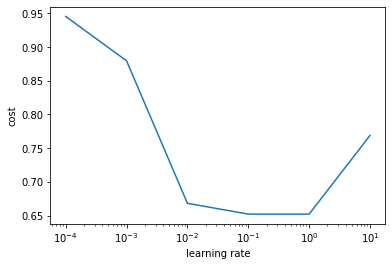

In [244]:
import matplotlib.pyplot as plt
plt.plot(lr_list, costs_list)
plt.xscale("log")
plt.ylabel('cost')
plt.xlabel('learning rate');

## From the above plot we can see that we should select learning rate 0.1. 
- Different learning rates give different costs .
- If the learning rate is too large (10), the cost may oscillate up and down. Using 1 still eventually ends up at a good value for the cost.
- A lower cost doesn't mean a better model. You have to check if there is possibly over-fitting. It happens when the training accuracy is a lot higher than the test accuracy.

# Compare your model with one using a machine learning library to compute logistic regression

In [245]:
# create logistic regression object
log_reg = LogisticRegression()
log_reg.fit(X_train[['Glucose', 'BMI']], y_trn)
log_reg.score(X_val[['Glucose', 'BMI']], y_vl)

0.7857142857142857

Sklearn model performs better than my model, because it has optimized solver.

# Retrain your model using three features of your choice

In [0]:
X_3feat_train = X_train[['Age', 'Insulin', 'BloodPressure']].values.reshape(X_train[['Age', 'Insulin', 'BloodPressure']].shape[1],X_train[['Age', 'Insulin', 'BloodPressure']].shape[0])
X_3feat_val = X_val[['Age', 'Insulin', 'BloodPressure']].values.reshape(X_val[['Age', 'Insulin', 'BloodPressure']].shape[1],X_val[['Age', 'Insulin', 'BloodPressure']].shape[0])

In [247]:
max_iter = 600
lr = 0.01
w, b = initialize_with_zeros(X_3feat_train.shape[0])
w3, b3, _ = LRGradDesc(w, b, X_3feat_train, y_train, X_3feat_val, y_val, num_iterations=max_iter + 1, learning_rate=lr, is_print=True);

Iteration 0:  initial_train cost 0.9533268340980275, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 1:  train cost 0.9519503394044824, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 100:  weights [[ 0.00309175]
 [ 0.00310383]
 [-0.00203471]] bias 0.6614235027981578 initial_train cost 0.8403892544265985, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 200:  weights [[0.00249044]
 [0.0080017 ]
 [0.00027505]] bias 0.3935454503104045 initial_train cost 0.7680221343874647, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 300:  weights [[-0.00054454]
 [ 0.01385195]
 [ 0.00538028]] bias 0.18266758369034147 initial_train cost 0.7230980983214663, train accuracy  35.993485342019554, validation accuracy 30.519480519480524
Iteration 400:  weights [[-0.00497501]
 [ 0.02001417]
 [ 0.0120182 ]] bias 0.01786797276562958 initial_train cost 0.69559645970427

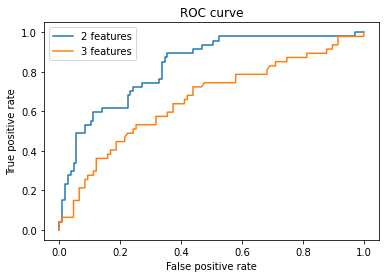

In [248]:
log_reg.fit(X_train[['Glucose', 'BMI']], y_trn)
y_pred_2 = log_reg.predict_proba(X_val[['Glucose', 'BMI']])

log_reg.fit(X_train[['Age', 'Insulin', 'BloodPressure']], y_trn)
y_pred_3 = log_reg.predict_proba(X_val[['Age', 'Insulin', 'BloodPressure']])

fpr_2, tpr_2, _ = roc_curve(y_vl.values, y_pred_2[:,1])
fpr_3, tpr_3, _ = roc_curve(y_vl.values, y_pred_3[:,1])

plt.plot(fpr_2, tpr_2, label='2 features')
plt.plot(fpr_3, tpr_3, label='3 features')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show();

## We can see that 2 features model is better. It is obvious, because for this model we used more important features.